# Scratchpad for Purchase Analysis

### Imports

In [1]:
import datetime
import glob
import os
import re
import time
import matplotlib.pyplot as plt
import pandas as pd
import requests
import statsmodels.api as sm
import scipy as sp
from bs4 import BeautifulSoup
from matplotlib import rcParams
from matplotlib.ticker import EngFormatter
from matplotlib.ticker import MaxNLocator
import urllib


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 50)  # or 1000



### Constants

In [2]:
RE_NO_BREAK_SPACE = re.compile(r"( )")
KEYS = []
NOW = datetime.datetime.now().strftime('%Y_%m_%d')
COLOURS = ['#db5f57', '#dbc257', '#91db57', '#57d3db', '#5770db', '#a157db', '#db57b2']
URLS_P24 = [
    "https://www.property24.com/for-sale/sea-point/cape-town/western-cape/11021",
    "https://www.property24.com/for-sale/observatory/cape-town/western-cape/10157",
    "https://www.property24.com/for-sale/gardens/cape-town/western-cape/9145",
    "https://www.property24.com/for-sale/cape-town-city-centre/cape-town/western-cape/9138",
    "https://www.property24.com/for-sale/rondebosch/cape-town/western-cape/8682",
    "https://www.property24.com/for-sale/muizenberg/cape-town/western-cape/9025",
    "https://www.property24.com/for-sale/constantia/cape-town/western-cape/11742",
    "https://www.property24.com/for-sale/woodstock/cape-town/western-cape/10164",
    "https://www.property24.com/for-sale/newlands/cape-town/western-cape/8679",
    "https://www.property24.com/for-sale/green-point/cape-town/western-cape/11017",
    "https://www.property24.com/for-sale/claremont-upper/cape-town/western-cape/14225",
    "https://www.property24.com/for-sale/plumstead/cape-town/western-cape/10094",
    "https://www.property24.com/for-sale/camps-bay/cape-town/western-cape/11014",
    "https://www.property24.com/for-sale/claremont/cape-town/western-cape/11741",
    "https://www.property24.com/for-sale/fresnaye/cape-town/western-cape/11016"
]
URLS_CARS = [
    "https://www.cars.co.za/searchVehicle.php?new_or_used=Used&make_model=&vfs_area=Western+Cape&agent_locality=&price_range=50000+-+74999%7C75000+-+99999%7C100000+-+124999%7C125000+-+149999&os=&locality=&body_type_exact=Hatchback&transmission=&fuel_type=&login_type=&mapped_colour=black%7Cgrey%7Csilver&vfs_year=&vfs_mileage=&vehicle_axle_config=&keyword=&sort=vfs_price",
]
URLS_AUTOTRADER = [
    "https://www.autotrader.co.za/cars-for-sale/western-cape/p-9?price=50001-to-200000&bodytype=hatchback&bodytype=sedan&colour=Black&colour=Grey&colour=Silver&colour=White&isused=True",
]
URLS_WEBUYCARS = [
    "https://www.webuycars.co.za/buy-a-car?subcategory=Hatchback&DealerKey=%5B%22Cape%20Town%202%20Phumelela%20Park%20Branch%22,%22Cape%20Town%201%20Montague%20Drive%20Branch%22%5D&Priced_Amount_Gte=50000&Priced_Amount_Lte=150000&BodyType=%5B%22Hatchback%22%5D&Colour=%5B%22Silver%22,%22White%22,%22Grey%22,%22Black%22%5D&page=1"
]
IN_DEVELOPMENT = True

# Prices of cars with Bluetooth

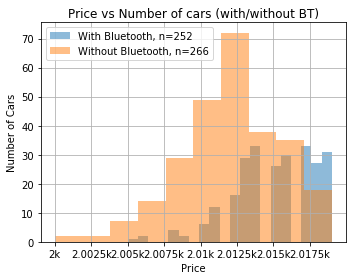

In [8]:
csv_path = "CSVs/2019_11_21/www.cars.co.za.csv"
df = pd.read_csv(csv_path)
bt = df[df["features_bluetooth"] == True]
not_bt = df[df["features_bluetooth"] == False]
num_bins_bt = int(round((bt["price"].max() - bt["price"].min()) / 10000, 0))
num_bins_not_bt = int(round((not_bt["price"].max() - not_bt["price"].min()) / 10000, 0))


fig, ax = plt.subplots(figsize=(5, 4))
plt.grid(True)
ax.xaxis.set_major_formatter(EngFormatter(sep=""))
num_bins = 20
ax.hist(bt["year"], bins=num_bins, alpha=0.5, label=f"With Bluetooth, n={len(bt['price'].index)}")
ax.hist(not_bt["year"], bins=num_bins_not_bt, alpha=0.5, label=f"Without Bluetooth, n={len(not_bt['price'].index)}")

ax.set_title("Price vs Number of cars (with/without BT)")
ax.set_xlabel("Price")
ax.set_ylabel("Number of Cars")
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("readme_resources/bt_hist.png")
plt.show()


In [6]:
bt.describe()

price    odometer_km         year  engine_power_max_kW  \
count  252.000000     252.000000     252.000000   252.000000            
mean   126240.829365  75371.888889   2015.063492  66.019841             
std    20999.875754   53814.676245   2.868280     17.226277             
min    54995.000000   10.000000      2005.000000  48.000000             
25%    110450.000000  34098.500000   2013.000000  55.000000             
50%    129900.000000  68500.000000   2015.000000  64.000000             
75%    142623.750000  109691.000000  2017.000000  73.000000             
max    179900.000000  320000.000000  2019.000000  147.000000            

       engine_size_l  engine_fuel_tank_l  performace_0_to_100_s  \
count  252.000000     252.000000          201.000000              
mean   1.259127       41.690476           11.925373               
std    0.239763       6.530302            1.557017                
min    0.900000       28.000000           7.000000                
25%    1.000000       35.000000           11.200000               
50%    1.200000       45.000000           12.200000               
75%    1.400000       45.000000           12.900000               
max    2.000000       56.000000           15.800000               

       performace_speed_max_kmph  economy_fuel_consumption_lpkm  \
count  249.000000                 252.000000                      
mean   172.485944                 5.574603                        
std    16.253561                  0.736573                        
min    152.000000                 3.600000                        
25%    161.000000                 5.000000                        
50%    171.000000                 5.500000                        
75%    178.000000                 6.200000                        
max    238.000000                 7.700000                        

       economy_fuel_range_km  economy_CO2_gpkm  safety_airbag_quantity  \
count  244.000000             246.000000        251.000000               
mean   755.479508             129.983740        2.756972                 
std    113.782894             15.991826         1.668742                 
min    500.000000             95.000000         1.000000                 
25%    700.000000             118.000000        2.000000                 
50%    727.500000             129.000000        2.000000                 
75%    794.000000             141.000000        4.000000                 
max    1170.000000            180.000000        7.000000                 

       specs_doors  specs_seats  specs_kerb_weight  history_num_owners  
count  252.000000   252.000000   252.000000         0.0                 
mean   4.865079     4.948413     1012.837302       NaN                  
std    0.502633     0.221633     149.698879        NaN                  
min    3.000000     4.000000     693.000000        NaN                  
25%    5.000000     5.000000     952.000000        NaN                  
50%    5.000000     5.000000     1046.000000       NaN                  
75%    5.000000     5.000000     1089.000000       NaN                  
max    5.000000     5.000000     1420.000000       NaN

In [7]:
not_bt.describe()

price    odometer_km         year  engine_power_max_kW  \
count  266.000000     265.000000     266.000000   191.000000            
mean   105147.308271  106178.290566  2012.240602  64.162304             
std    25445.051004   51629.612295   3.600106     16.283664             
min    49950.000000   10.000000      2000.000000  45.000000             
25%    89900.000000   70945.000000   2010.000000  51.000000             
50%    99995.000000   108448.000000  2012.000000  62.000000             
75%    124900.000000  139512.000000  2014.750000  73.000000             
max    149999.000000  245000.000000  2019.000000  147.000000            

       engine_size_l  engine_fuel_tank_l  performace_0_to_100_s  \
count  191.000000     191.000000          186.000000              
mean   1.317801       41.790576           12.753763               
std    0.252977       6.172785            1.710322                
min    0.900000       35.000000           6.900000                
25%    1.100000       35.000000           11.500000               
50%    1.300000       42.000000           12.850000               
75%    1.400000       45.000000           14.000000               
max    2.000000       55.000000           16.500000               

       performace_speed_max_kmph  economy_fuel_consumption_lpkm  \
count  190.000000                 191.000000                      
mean   170.178947                 5.798429                        
std    15.284933                  1.089687                        
min    145.000000                 3.400000                        
25%    157.000000                 4.900000                        
50%    168.000000                 5.700000                        
75%    177.000000                 6.350000                        
max    236.000000                 10.000000                       

       economy_fuel_range_km  economy_CO2_gpkm  safety_airbag_quantity  \
count  179.000000             178.000000        179.000000               
mean   735.810056             133.387640        2.882682                 
std    94.227120              19.511007         1.558839                 
min    500.000000             89.000000         1.000000                 
25%    682.000000             117.000000        2.000000                 
50%    738.000000             132.000000        2.000000                 
75%    776.000000             144.750000        4.000000                 
max    1324.000000            180.000000        7.000000                 

       specs_doors  specs_seats  specs_kerb_weight  history_num_owners  
count  191.000000   191.000000   188.000000         0.0                 
mean   4.947644     4.884817     988.292553        NaN                  
std    0.320168     0.320082     130.763265        NaN                  
min    3.000000     4.000000     788.000000        NaN                  
25%    5.000000     5.000000     880.000000        NaN                  
50%    5.000000     5.000000     972.500000        NaN                  
75%    5.000000     5.000000     1056.000000       NaN                  
max    5.000000     5.000000     1370.000000       NaN

In [151]:
df1 = sorted(df["colour"].unique().astype(str))
colours = {
    "white": re.compile("(white)"),
    "grey": re.compile("(grey|gray|charcoal)"),
    "silver": re.compile("(silver)"),
    "black": re.compile("(black)"),
    "nan": re.compile("(nan)"),
    "blue": re.compile("(blue|sea)"),
    "orange": re.compile("(orange)"),
    "red": re.compile("(pepper|red)"),
}

In [155]:
actual = []
for i, item in enumerate(df1):
    actual.append([item])
    for k, v in colours.items():
        if re.search(v, item):
            actual[i].append(k)


# Print out images of the different models

In [113]:
csv_path = "CSVs/2019_11_21/www.cars.co.za_pruned.csv"
df = pd.read_csv(csv_path)

In [114]:
df['model'].fillna('missing')
df_sorted = df.assign(model_freq=df.apply(lambda x: df.model.value_counts()\
  .to_dict()[x.model], axis=1))\
  .sort_values(by='model_freq', ascending=False)
# df_sorted

print("Starting")
models = list(df_sorted["model"].unique())
# models
image_links = []
for i, row in df_sorted.iterrows():
    if row["model"] in models and not pd.isna(row["img_link"]):
#         print(row["img_link"])
        image_links.append((row["img_link"], row["model"]))
        models.remove(row["model"])


Starting


29
.............................
Plotting


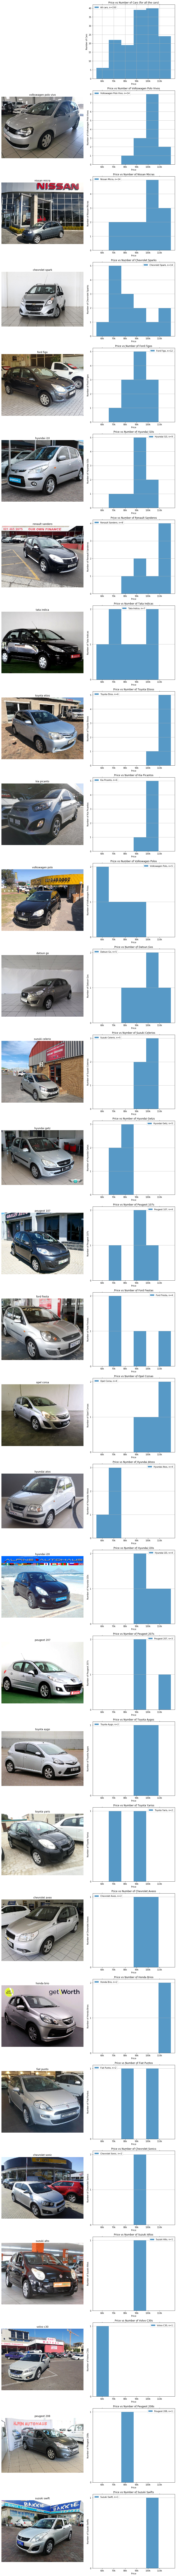

In [115]:
# image_links = image_links[:4]
fig, axes = plt.subplots(len(image_links) + 1, 2, 
                         figsize=(12, 6*len(image_links)), 
                        sharex='col')
plt.grid(True)
num_bins = int(round((df["price"].max() - df["price"].min()) / 10000, 0))
n, bins, patches = axes[0, 1].hist(
    df["price"], 
    bins=num_bins,
    alpha=0.75, 
    label=f"All cars, n={len(df.index)}")
axes[0, 0].axis("off")
axes[0, 1].tick_params(axis='x', reset=True)
axes[0, 1].set_title(f"Price vs Number of Cars (for all the cars)")
axes[0, 1].set_xlabel("Price")
axes[0, 1].set_ylabel(f"Number of Cars")
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True)
axes[-1, 1].set_xticks(range(
    int(round(df["price"].min(), -4)), 
    int(round(df["price"].max(), -4)), 
    10000))

print(len(image_links))
for i, (link, model) in enumerate(image_links):
    print(".", end="")
    curr_model = df[df["model"] == model]
    axes[i+1, 1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[i+1, 1].grid(True)
    axes[i+1, 1].xaxis.set_major_formatter(EngFormatter(sep=""))
    axes[i+1, 1].tick_params(axis='x', reset=True)
    axes[i+1, 1].set_xticks(axes[-1, 1].get_xticks())
    axes[i+1, 1].hist(curr_model["price"], 
                      bins=bins, 
                      alpha=0.75, 
                      label=f"{model.title()}, n={len(curr_model.index)}")
    axes[i+1, 1].set_title(f"Price vs Number of {model.title()}s")
    axes[i+1, 1].set_xlabel("Price")
    axes[i+1, 1].set_ylabel(f"Number of {model.title()}s")
    axes[i+1, 1].legend(loc='best')
    try:
        f = urllib.request.urlopen(link)
        a = plt.imread(f, format='jpg')
        axes[i+1, 0].imshow(a)
        axes[i+1, 0].set_title(model)
        axes[i+1, 0].axis('off')
    except:
        pass
print("\nPlotting")
plt.tight_layout()
plt.savefig("readme_resources/models_vs_price.png")